Joshua Pauly 
Assignment 2 Image classification

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# From Keras testing if image is corrupted
import os

num_skipped = 0
for folder_name in ("buildings", "forest", "glacier", "mountain", "sea", "street"):
    folder_path = os.path.join("seg_train\seg_train",folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [5]:
img_size = (224,224)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "seg_train\seg_train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=img_size,
    batch_size=batch_size,
)



Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.


In [6]:
test_images = tf.keras.utils.image_dataset_from_directory(
    "seg_test\seg_test",
    seed=1337,
    image_size=img_size
)

Found 3000 files belonging to 6 classes.


Visualize the first 25 images

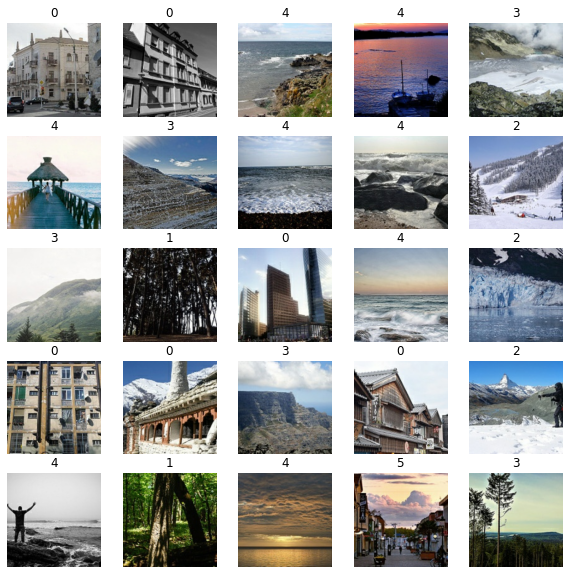

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Image augmentation is used to increase training set and randomly shift images

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomTranslation(0.14,0.14),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ]
)

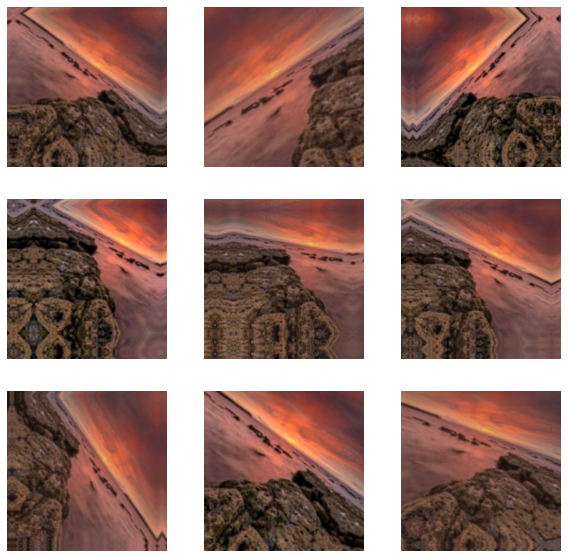

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Fix RGB Channel

In [10]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Apply data augmentation to training set

In [11]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [12]:
CB = [
            keras.callbacks.ModelCheckpoint(
            filepath="fine_tuning.keras",
            save_best_only=True,
            monitor="val_loss"),
    
            keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0005,
            patience=10)
]

In [13]:
# Resnet50 Model
Resnet50_base  = keras.applications.ResNet50V2(
    weights="imagenet",
    #weights=None,
    include_top=False)

#Resnet50_base.trainable = True
Resnet50_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(Resnet50_base.trainable_weights))

Resnet50_base.summary()

94668760/94668760 [==============================] - 7s 0us/step
This is the number of trainable weights before freezing the conv base: 0
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,

                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, None, None,   16640       ['conv2_block2_2_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv2_block2_out (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_conv[0][0]']    
                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, None, None,   1024       ['conv2_block2_out[0][0]']       
 ormalization)                  256)                                                              
                                                                                                  
 conv2_blo

 vation)                        512)                                                              
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, None, None,   65536       ['conv3_block2_preact_relu[0][0]'
                                128)                             ]                                
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, None, None,   0          ['conv3_block2_1_bn[0][0]']      
 n)                             128)                                                              
          

 conv3_block4_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block4_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block4_2_relu (Activatio  (None, None, None,   0          ['conv3_block4_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, None, None,   0          ['conv3_block3_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block4_2_relu[0][0]']    
          

                                                                                                  
 conv4_block3_preact_bn (BatchN  (None, None, None,   4096       ['conv4_block2_out[0][0]']       
 ormalization)                  1024)                                                             
                                                                                                  
 conv4_block3_preact_relu (Acti  (None, None, None,   0          ['conv4_block3_preact_bn[0][0]'] 
 vation)                        1024)                                                             
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, None, None,   262144      ['conv4_block3_preact_relu[0][0]'
                                256)                             ]                                
                                                                                                  
 conv4_blo

 g2D)                           256)                                                              
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, None, None,   589824      ['conv4_block5_2_pad[0][0]']     
                                256)                                                              
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block5_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, None, None,   0          ['conv4_block5_2_bn[0][0]']      
 n)                             256)                                                              
          

 conv5_block1_3_conv (Conv2D)   (None, None, None,   1050624     ['conv5_block1_2_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 conv5_block1_out (Add)         (None, None, None,   0           ['conv5_block1_0_conv[0][0]',    
                                2048)                             'conv5_block1_3_conv[0][0]']    
                                                                                                  
 conv5_block2_preact_bn (BatchN  (None, None, None,   8192       ['conv5_block1_out[0][0]']       
 ormalization)                  2048)                                                             
                                                                                                  
 conv5_block2_preact_relu (Acti  (None, None, None,   0          ['conv5_block2_preact_bn[0][0]'] 
 vation)  

In [14]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.resnet_v2.preprocess_input(x)
x = Resnet50_base(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)
resnet50_model = keras.Model(inputs, outputs)
resnet50_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
resnet50_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0     

In [15]:
def plot_history(history,title=''):  
    if title!='':
        title+=' '
    #Ploting the Loss and Accuracy Curves
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    #Loss
    sns.lineplot(data = history.history['loss'], label = 'Training Loss', ax = ax[0])
    sns.lineplot(data = history.history['val_loss'], label = 'Validation Loss', ax = ax[0])
    ax[0].legend(loc = 'upper right')
    ax[0].set_title(title+'Loss')
    #Accuracy
    sns.lineplot(data = history.history['accuracy'], label = 'Training Accuracy', ax = ax[1])
    sns.lineplot(data = history.history['val_accuracy'], label = 'Validation Accuracy', ax = ax[1])
    ax[1].legend(loc = 'lower right')
    ax[1].set_title(title+'Accuracy')

In [16]:
history_resnet50 = resnet50_model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=CB
    )
resnet50_model = keras.models.load_model("fine_tuning.keras")

Epoch 1/15
88/88 [==============================] - 562s 6s/step - loss: 1.1311 - accuracy: 0.6136 - val_loss: 0.3579 - val_accuracy: 0.8817
Epoch 2/15
88/88 [==============================] - 552s 6s/step - loss: 0.6679 - accuracy: 0.7646 - val_loss: 0.3022 - val_accuracy: 0.8956
Epoch 3/15
88/88 [==============================] - 570s 6s/step - loss: 0.5720 - accuracy: 0.7921 - val_loss: 0.2853 - val_accuracy: 0.8988
Epoch 4/15
88/88 [==============================] - 585s 7s/step - loss: 0.5113 - accuracy: 0.8161 - val_loss: 0.2803 - val_accuracy: 0.9009
Epoch 5/15
88/88 [==============================] - 562s 6s/step - loss: 0.4958 - accuracy: 0.8188 - val_loss: 0.2698 - val_accuracy: 0.8970
Epoch 6/15
88/88 [==============================] - 557s 6s/step - loss: 0.4748 - accuracy: 0.8305 - val_loss: 0.2658 - val_accuracy: 0.8974
Epoch 7/15
88/88 [==============================] - 555s 6s/step - loss: 0.4699 - accuracy: 0.8296 - val_loss: 0.2526 - val_accuracy: 0.9066
Epoch 8/15
88

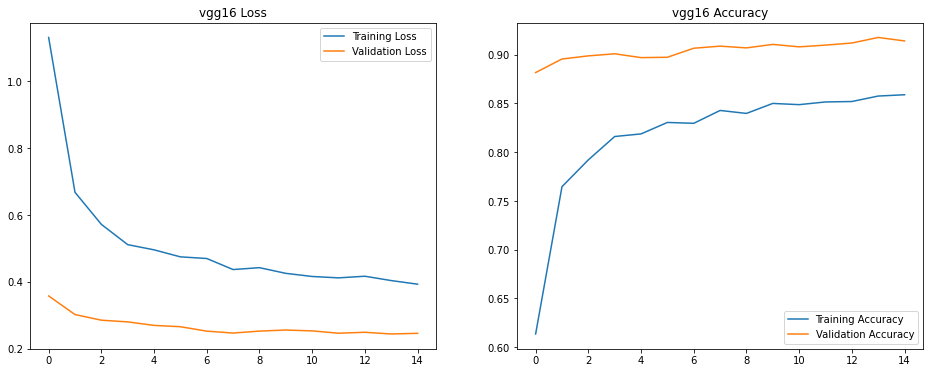

In [17]:
plot_history(history_resnet50,'Resnet50_V2')

In [18]:
#EfficientNet V2L Model
EfficientNet_base = keras.applications.EfficientNetV2L(
    weights="imagenet",
    include_top=False)

#EfficientNet_base.trainable = True
EfficientNet_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(EfficientNet_base.trainable_weights))

EfficientNet_base.summary()

473176280/473176280 [==============================] - 34s 0us/step
This is the number of trainable weights before freezing the conv base: 0
Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, No

 ization)                       128)                                                              
                                                                                                  
 block2a_expand_activation (Act  (None, None, None,   0          ['block2a_expand_bn[0][0]']      
 ivation)                       128)                                                              
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   8192        ['block2a_expand_activation[0][0]
                                64)                              ']                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   256        ['block2a_project_conv[0][0]']   
 lization)                      64)                                                               
          

 block2e_project_conv (Conv2D)  (None, None, None,   16384       ['block2e_expand_activation[0][0]
                                64)                              ']                               
                                                                                                  
 block2e_project_bn (BatchNorma  (None, None, None,   256        ['block2e_project_conv[0][0]']   
 lization)                      64)                                                               
                                                                                                  
 block2e_drop (Dropout)         (None, None, None,   0           ['block2e_project_bn[0][0]']     
                                64)                                                               
                                                                                                  
 block2e_add (Add)              (None, None, None,   0           ['block2e_drop[0][0]',           
          

                                                                                                  
 block3b_drop (Dropout)         (None, None, None,   0           ['block3b_project_bn[0][0]']     
                                96)                                                               
                                                                                                  
 block3b_add (Add)              (None, None, None,   0           ['block3b_drop[0][0]',           
                                96)                               'block3a_project_bn[0][0]']     
                                                                                                  
 block3c_expand_conv (Conv2D)   (None, None, None,   331776      ['block3b_add[0][0]']            
                                384)                                                              
                                                                                                  
 block3c_e

 lization)                      96)                                                               
                                                                                                  
 block3f_drop (Dropout)         (None, None, None,   0           ['block3f_project_bn[0][0]']     
                                96)                                                               
                                                                                                  
 block3f_add (Add)              (None, None, None,   0           ['block3f_drop[0][0]',           
                                96)                               'block3e_add[0][0]']            
                                                                                                  
 block3g_expand_conv (Conv2D)   (None, None, None,   331776      ['block3f_add[0][0]']            
                                384)                                                              
          

 block4b_se_squeeze (GlobalAver  (None, 768)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 768)    37632       ['block4b_se_reduce[0][0]']      
                                                                                                  
 block4b_se_excite (Multiply)   (None, None, None,   0           ['block4b_activation[0][0]',     
          

                                                                                                  
 block4d_se_squeeze (GlobalAver  (None, 768)         0           ['block4d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4d_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4d_se_squeeze[0][0]']     
                                                                                                  
 block4d_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4d_se_reshape[0][0]']     
                                                                                                  
 block4d_se_expand (Conv2D)     (None, 1, 1, 768)    37632       ['block4d_se_reduce[0][0]']      
                                                                                                  
 block4d_s

 )                              768)                                                              
                                                                                                  
 block4f_se_squeeze (GlobalAver  (None, 768)         0           ['block4f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4f_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4f_se_squeeze[0][0]']     
                                                                                                  
 block4f_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4f_se_reshape[0][0]']     
                                                                                                  
 block4f_se_expand (Conv2D)     (None, 1, 1, 768)    37632       ['block4f_se_reduce[0][0]']      
          

 block4h_activation (Activation  (None, None, None,   0          ['block4h_bn[0][0]']             
 )                              768)                                                              
                                                                                                  
 block4h_se_squeeze (GlobalAver  (None, 768)         0           ['block4h_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4h_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4h_se_squeeze[0][0]']     
                                                                                                  
 block4h_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4h_se_reshape[0][0]']     
                                                                                                  
 block4h_s

                                                                                                  
 block4j_activation (Activation  (None, None, None,   0          ['block4j_bn[0][0]']             
 )                              768)                                                              
                                                                                                  
 block4j_se_squeeze (GlobalAver  (None, 768)         0           ['block4j_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4j_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4j_se_squeeze[0][0]']     
                                                                                                  
 block4j_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4j_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block5b_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5b_se_squeeze[0][0]']     
                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, None, None,   0           ['block5b_activation[0][0]',     
                                1344)                             'block5b_se_expand[0][0]']      
          

 block5d_se_squeeze (GlobalAver  (None, 1344)        0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5d_se_squeeze[0][0]']     
                                                                                                  
 block5d_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5d_se_reshape[0][0]']     
                                                                                                  
 block5d_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5d_se_reduce[0][0]']      
                                                                                                  
 block5d_se_excite (Multiply)   (None, None, None,   0           ['block5d_activation[0][0]',     
          

                                                                                                  
 block5f_se_squeeze (GlobalAver  (None, 1344)        0           ['block5f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5f_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5f_se_squeeze[0][0]']     
                                                                                                  
 block5f_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5f_se_reshape[0][0]']     
                                                                                                  
 block5f_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5f_se_reduce[0][0]']      
                                                                                                  
 block5f_s

 )                              1344)                                                             
                                                                                                  
 block5h_se_squeeze (GlobalAver  (None, 1344)        0           ['block5h_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5h_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5h_se_squeeze[0][0]']     
                                                                                                  
 block5h_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5h_se_reshape[0][0]']     
                                                                                                  
 block5h_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5h_se_reduce[0][0]']      
          

 block5j_activation (Activation  (None, None, None,   0          ['block5j_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5j_se_squeeze (GlobalAver  (None, 1344)        0           ['block5j_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5j_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5j_se_squeeze[0][0]']     
                                                                                                  
 block5j_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5j_se_reshape[0][0]']     
                                                                                                  
 block5j_s

                                                                                                  
 block5l_activation (Activation  (None, None, None,   0          ['block5l_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5l_se_squeeze (GlobalAver  (None, 1344)        0           ['block5l_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5l_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5l_se_squeeze[0][0]']     
                                                                                                  
 block5l_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5l_se_reshape[0][0]']     
          

 )                              1344)                                                             
                                                                                                  
 block5n_activation (Activation  (None, None, None,   0          ['block5n_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5n_se_squeeze (GlobalAver  (None, 1344)        0           ['block5n_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5n_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5n_se_squeeze[0][0]']     
                                                                                                  
 block5n_s

 block5p_bn (BatchNormalization  (None, None, None,   5376       ['block5p_dwconv2[0][0]']        
 )                              1344)                                                             
                                                                                                  
 block5p_activation (Activation  (None, None, None,   0          ['block5p_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5p_se_squeeze (GlobalAver  (None, 1344)        0           ['block5p_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5p_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5p_se_squeeze[0][0]']     
          

                                                                                                  
 block5r_bn (BatchNormalization  (None, None, None,   5376       ['block5r_dwconv2[0][0]']        
 )                              1344)                                                             
                                                                                                  
 block5r_activation (Activation  (None, None, None,   0          ['block5r_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5r_se_squeeze (GlobalAver  (None, 1344)        0           ['block5r_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5r_s

 2D)                            1344)                            ']                               
                                                                                                  
 block6a_bn (BatchNormalization  (None, None, None,   5376       ['block6a_dwconv2[0][0]']        
 )                              1344)                                                             
                                                                                                  
 block6a_activation (Activation  (None, None, None,   0          ['block6a_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 1344)        0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block6c_activation (Activation  (None, None, None,   0          ['block6c_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 2304)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6c_se_reshape[0][0]']     
                                                                                                  
 block6c_s

                                                                                                  
 block6e_activation (Activation  (None, None, None,   0          ['block6e_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6e_se_squeeze (GlobalAver  (None, 2304)        0           ['block6e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6e_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6e_se_squeeze[0][0]']     
                                                                                                  
 block6e_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6e_se_reshape[0][0]']     
          

 )                              2304)                                                             
                                                                                                  
 block6g_activation (Activation  (None, None, None,   0          ['block6g_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6g_se_squeeze (GlobalAver  (None, 2304)        0           ['block6g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6g_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6g_se_squeeze[0][0]']     
                                                                                                  
 block6g_s

 block6i_bn (BatchNormalization  (None, None, None,   9216       ['block6i_dwconv2[0][0]']        
 )                              2304)                                                             
                                                                                                  
 block6i_activation (Activation  (None, None, None,   0          ['block6i_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6i_se_squeeze (GlobalAver  (None, 2304)        0           ['block6i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6i_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6i_se_squeeze[0][0]']     
          

                                                                                                  
 block6k_bn (BatchNormalization  (None, None, None,   9216       ['block6k_dwconv2[0][0]']        
 )                              2304)                                                             
                                                                                                  
 block6k_activation (Activation  (None, None, None,   0          ['block6k_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6k_se_squeeze (GlobalAver  (None, 2304)        0           ['block6k_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6k_s

 2D)                            2304)                            ']                               
                                                                                                  
 block6m_bn (BatchNormalization  (None, None, None,   9216       ['block6m_dwconv2[0][0]']        
 )                              2304)                                                             
                                                                                                  
 block6m_activation (Activation  (None, None, None,   0          ['block6m_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6m_se_squeeze (GlobalAver  (None, 2304)        0           ['block6m_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block6o_dwconv2 (DepthwiseConv  (None, None, None,   20736      ['block6o_expand_activation[0][0]
 2D)                            2304)                            ']                               
                                                                                                  
 block6o_bn (BatchNormalization  (None, None, None,   9216       ['block6o_dwconv2[0][0]']        
 )                              2304)                                                             
                                                                                                  
 block6o_activation (Activation  (None, None, None,   0          ['block6o_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6o_se_squeeze (GlobalAver  (None, 2304)        0           ['block6o_activation[0][0]']     
 agePoolin

                                                                                                  
 block6q_dwconv2 (DepthwiseConv  (None, None, None,   20736      ['block6q_expand_activation[0][0]
 2D)                            2304)                            ']                               
                                                                                                  
 block6q_bn (BatchNormalization  (None, None, None,   9216       ['block6q_dwconv2[0][0]']        
 )                              2304)                                                             
                                                                                                  
 block6q_activation (Activation  (None, None, None,   0          ['block6q_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6q_s

 ivation)                       2304)                                                             
                                                                                                  
 block6s_dwconv2 (DepthwiseConv  (None, None, None,   20736      ['block6s_expand_activation[0][0]
 2D)                            2304)                            ']                               
                                                                                                  
 block6s_bn (BatchNormalization  (None, None, None,   9216       ['block6s_dwconv2[0][0]']        
 )                              2304)                                                             
                                                                                                  
 block6s_activation (Activation  (None, None, None,   0          ['block6s_bn[0][0]']             
 )                              2304)                                                             
          

 block6u_expand_activation (Act  (None, None, None,   0          ['block6u_expand_bn[0][0]']      
 ivation)                       2304)                                                             
                                                                                                  
 block6u_dwconv2 (DepthwiseConv  (None, None, None,   20736      ['block6u_expand_activation[0][0]
 2D)                            2304)                            ']                               
                                                                                                  
 block6u_bn (BatchNormalization  (None, None, None,   9216       ['block6u_dwconv2[0][0]']        
 )                              2304)                                                             
                                                                                                  
 block6u_activation (Activation  (None, None, None,   0          ['block6u_bn[0][0]']             
 )        

                                                                                                  
 block6w_expand_activation (Act  (None, None, None,   0          ['block6w_expand_bn[0][0]']      
 ivation)                       2304)                                                             
                                                                                                  
 block6w_dwconv2 (DepthwiseConv  (None, None, None,   20736      ['block6w_expand_activation[0][0]
 2D)                            2304)                            ']                               
                                                                                                  
 block6w_bn (BatchNormalization  (None, None, None,   9216       ['block6w_dwconv2[0][0]']        
 )                              2304)                                                             
                                                                                                  
 block6w_a

 ization)                       2304)                                                             
                                                                                                  
 block6y_expand_activation (Act  (None, None, None,   0          ['block6y_expand_bn[0][0]']      
 ivation)                       2304)                                                             
                                                                                                  
 block6y_dwconv2 (DepthwiseConv  (None, None, None,   20736      ['block6y_expand_activation[0][0]
 2D)                            2304)                            ']                               
                                                                                                  
 block6y_bn (BatchNormalization  (None, None, None,   9216       ['block6y_dwconv2[0][0]']        
 )                              2304)                                                             
          

 block7b_dwconv2 (DepthwiseConv  (None, None, None,   34560      ['block7b_expand_activation[0][0]
 2D)                            3840)                            ']                               
                                                                                                  
 block7b_bn (BatchNormalization  (None, None, None,   15360      ['block7b_dwconv2[0][0]']        
 )                              3840)                                                             
                                                                                                  
 block7b_activation (Activation  (None, None, None,   0          ['block7b_bn[0][0]']             
 )                              3840)                                                             
                                                                                                  
 block7b_se_squeeze (GlobalAver  (None, 3840)        0           ['block7b_activation[0][0]']     
 agePoolin

                                                                                                  
 block7d_dwconv2 (DepthwiseConv  (None, None, None,   34560      ['block7d_expand_activation[0][0]
 2D)                            3840)                            ']                               
                                                                                                  
 block7d_bn (BatchNormalization  (None, None, None,   15360      ['block7d_dwconv2[0][0]']        
 )                              3840)                                                             
                                                                                                  
 block7d_activation (Activation  (None, None, None,   0          ['block7d_bn[0][0]']             
 )                              3840)                                                             
                                                                                                  
 block7d_s

 ivation)                       3840)                                                             
                                                                                                  
 block7f_dwconv2 (DepthwiseConv  (None, None, None,   34560      ['block7f_expand_activation[0][0]
 2D)                            3840)                            ']                               
                                                                                                  
 block7f_bn (BatchNormalization  (None, None, None,   15360      ['block7f_dwconv2[0][0]']        
 )                              3840)                                                             
                                                                                                  
 block7f_activation (Activation  (None, None, None,   0          ['block7f_bn[0][0]']             
 )                              3840)                                                             
          

 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 117,746,848
Trainable params: 0
Non-trainable params: 117,746,848
__________________________________________________________________________________________________


In [20]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.efficientnet_v2.preprocess_input(x)
x = EfficientNet_base(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)
EfficientNet_model = keras.Model(inputs, outputs)
EfficientNet_model.compile(optimizer="rmsprop",
               loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
EfficientNet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 batch_normalization_5 (Batc  (None, 62720)            250880    
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 256)               1605

In [21]:
history_EfficientNet = EfficientNet_model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=CB
    )
EfficientNet_model = keras.models.load_model("fine_tuning.keras")

Epoch 1/15
88/88 [==============================] - 2216s 25s/step - loss: 1.3475 - accuracy: 0.5333 - val_loss: 0.4072 - val_accuracy: 0.8603
Epoch 2/15
88/88 [==============================] - 2171s 25s/step - loss: 0.8247 - accuracy: 0.6912 - val_loss: 0.3647 - val_accuracy: 0.8721
Epoch 3/15
88/88 [==============================] - 2323s 26s/step - loss: 0.6755 - accuracy: 0.7460 - val_loss: 0.3622 - val_accuracy: 0.8696
Epoch 4/15
88/88 [==============================] - 2183s 25s/step - loss: 0.6007 - accuracy: 0.7726 - val_loss: 0.3109 - val_accuracy: 0.8899
Epoch 5/15
88/88 [==============================] - 2397s 27s/step - loss: 0.5836 - accuracy: 0.7800 - val_loss: 0.2976 - val_accuracy: 0.8988
Epoch 6/15
88/88 [==============================] - 2396s 27s/step - loss: 0.5448 - accuracy: 0.7993 - val_loss: 0.2943 - val_accuracy: 0.8970
Epoch 7/15
88/88 [==============================] - 2207s 25s/step - loss: 0.5314 - accuracy: 0.8087 - val_loss: 0.2867 - val_accuracy: 0.8963

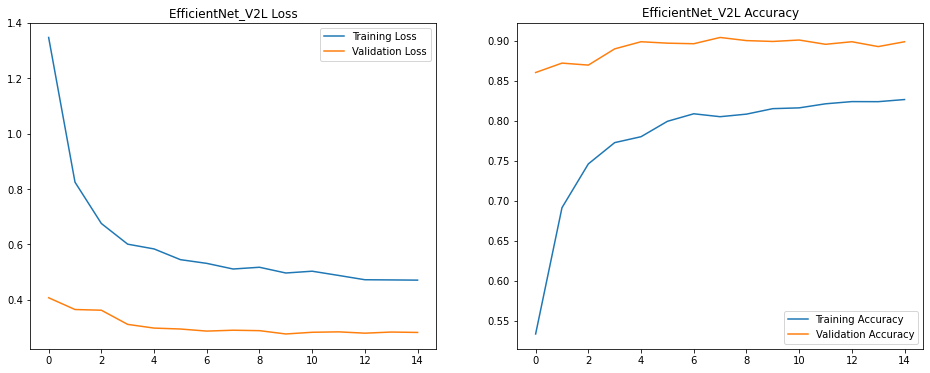

In [22]:
plot_history(history_EfficientNet,'EfficientNet_V2L')

In [23]:
resnet50_test=resnet50_model.evaluate(test_images)
EfficientNet_test=EfficientNet_model.evaluate(test_images)
compare_table=pd.DataFrame([resnet50_test,EfficientNet_test],columns=['loss','accuracy'],index=['Resnet50','EfficientNet'])
cm = sns.light_palette("green", as_cmap=True)
compare_table.head().style.background_gradient(cmap=cm)

94/94 [==============================] - 102s 1s/step - loss: 0.2564 - accuracy: 0.9063


,loss,accuracy
Resnet50,0.256354,0.906333
EfficientNet,0.256354,0.906333


Sources:
    https://www.kaggle.com/code/concyclics/0-995-dog-or-cat-vgg-model-introduction
    https://keras.io/examples/vision/image_classification_from_scratch/
    https://keras.io/api/applications/efficientnet_v2/#efficientnetv2l-function
    https://keras.io/api/applications/resnet/#resnet50v2-function